In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [45]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )
train_data = datagen.flow_from_directory('C:\\Users\\santhosh\\OneDrive\\Desktop\\diabetic retinopathy\\train\\',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('C:\\Users\\santhosh\\OneDrive\\Desktop\\diabetic retinopathy\\validation\\',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
!pip install imutils
import os
from imutils import paths
from sklearn.utils import shuffle

In [4]:
width,height=224,224

imagePaths = list(paths.list_images('C:\\Users\\santhosh\\OneDrive\\Desktop\\diabetic retinopathy\\train\\'))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]   
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

(3662, 224, 224, 3)
(3662, 5)


In [13]:
data = data / 255.0

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_val.shape)
print("Train label:",y_train.shape)
print("Test label:",y_val.shape)

Train images: (2929, 224, 224, 3)
Test images: (733, 224, 224, 3)
Train label: (2929, 5)
Test label: (733, 5)
Train images: (2343, 224, 224, 3)
Test images: (586, 224, 224, 3)
Train label: (2343, 5)
Test label: (586, 5)


In [5]:
import efficientnet.tfkeras as efn

In [6]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.00001
        return lr
    elif epoch<=30:
        lr=0.00001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [14]:
from tensorflow.keras.applications.efficientnet import preprocess_input

x_train_efficientnet = preprocess_input(x_train)  # Preprocessing for EfficientNet
x_train_custom = x_train   


x_val_efficientnet = preprocess_input(x_val)  
x_val_custom = x_val                         


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Dense, Flatten, Input, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D

# EfficientNet Model
base_model1 = EfficientNetB0(
    input_shape=(224, 224, 3), weights='imagenet', include_top=False
)
model1_output = Flatten()(base_model1.output)

# Custom CNN Model
input_custom = Input(shape=(224, 224, 3))  # Define input layer for the custom model
x = Conv2D(32, (3, 3), activation='relu')(input_custom)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

custom_output = Flatten()(x)

# Combine Features
combined_features = Concatenate()([model1_output, custom_output])

# Add Classification Head
x = Dense(512, activation='relu')(combined_features)
x = Dropout(0.5)(x)
final_output = Dense(5, activation='softmax')(x)

# Define the Combined Model
combined_model = Model(inputs=[base_model1.input, input_custom], outputs=final_output)

# Compile the Model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Combined Model
combined_model.fit(
    [x_train_efficientnet, x_train_custom],  # Provide inputs for both models
    y_train,
    batch_size=32,
    callbacks=[early_stopping,lr_scheduler],
    epochs=100,
    validation_data=([x_val_efficientnet, x_val_custom], y_val),
      # Validation inputs
)





Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.5134 - loss: 9.1465 - val_accuracy: 0.2611 - val_loss: 1.6041 - learning_rate: 0.0010
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.6139 - loss: 1.0620 - val_accuracy: 0.0495 - val_loss: 5.3111 - learning_rate: 0.0010
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6306 - loss: 1.0253 - val_accuracy: 0.0495 - val_loss: 2.2907 - learning_rate: 0.0010
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.6336 - loss: 0.9808 - val_accuracy: 0.5051 - val_loss: 1.5343 - learning_rate: 0.0010
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.6728 - loss: 0.9143 - val_accuracy: 0.0495 - val_loss: 51.1115 - learning_rate: 0.0010
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.6929 - loss: 0.9083 - val_accuracy: 0.0495 - val_loss: 1889.9949 - learning_rate: 0.0010
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6422 - loss: 1.052

In [1]:

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history=retinopathy_model.fit(train_data,validation_data = valid_data,callbacks=[early_stopping,lr_scheduler],epochs=100,verbose=1)

NameError: name 'ReduceLROnPlateau' is not defined

In [42]:
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

# Custom CNN
def custom_model(input_shape):
    x = Input(shape=input_shape)
    y = Conv2D(32, (3, 3), activation='relu')(x)
    y = MaxPooling2D((2, 2))(y)
    y = Conv2D(64, (3, 3), activation='relu')(y)
    y = MaxPooling2D((2, 2))(y)
    y = Flatten()(y)
    y = Dense(128, activation='relu')(y)
    return Model(inputs=x, outputs=y)

# Instantiate Custom Model
custom_cnn = custom_model((224, 224, 3))

# EfficientNet as Output Layer
efficient_net = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in efficient_net.layers[-50:]:  # Fine-tune last 50 layers
    layer.trainable = True  # Freeze EfficientNet for transfer learning

# Combine Models
custom_input = Input(shape=(224, 224, 3))
custom_features = custom_cnn(custom_input)  # Custom model output
custom_features = Dense(128, activation='relu')(custom_features)  # Optional additional processing

# Reshape to EfficientNet input
reshaped = Dense(224 * 224 * 3, activation='relu')(custom_features)  # Flatten and match shape
reshaped = tf.keras.layers.Reshape((224, 224, 3))(reshaped)

# EfficientNet for final classification
efficient_features = efficient_net(reshaped)
pooled = GlobalAveragePooling2D()(efficient_features)
output = Dense(5, activation='softmax')(pooled)

# Final model
model = Model(inputs=custom_input, outputs=output)
model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_11 (Functional)      │ (None, 128)            │    23,907,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 150528)         │    19,418,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,397,992 (180.81 MB)

 Trainable params: 47,355,969 (180.65 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [43]:
from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history=model.fit( train_data,validation_data = valid_data,callbacks=[early_stopping,lr_scheduler],epochs=100,verbose=1)


Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.6015 - loss: 1.0898 - val_accuracy: 0.4938 - val_loss: 68.9238 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.6623 - loss: 0.9571 - val_accuracy: 0.4938 - val_loss: 28.9955 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.6927 - loss: 0.8903 - val_accuracy: 0.2189 - val_loss: 5.3396 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.6929 - loss: 0.8664 - val_accuracy: 0.1902 - val_loss: 2.0674 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.7027 - loss: 0.8498 - val_accuracy: 0.0684 - val_loss: 3.2081 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7271 - loss: 0.8138 - val_accuracy: 0.0930 - val_loss: 2.5441 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.6922 - loss: 0.8622 

KeyboardInterrupt: 

In [14]:
test_generator =datagen.flow_from_directory(
    directory=r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
result=retinopathy_model.evaluate(test_generator)

Found 3662 images belonging to 5 classes.


c:\Users\santhosh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 370ms/step - accuracy: 0.6909 - loss: 0.8312


In [15]:
y_pred = np.argmax(retinopathy_model.predict(test_generator), axis=-1) 
y_true = test_generator.classes 

correct_predictions = np.sum(y_pred == y_true)
total_samples = len(y_true)

print(f"Number of correctly classified samples: {correct_predictions} out of {total_samples}")
print(f"Accuracy (in numbers): {correct_predictions}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 393ms/step
Number of correctly classified samples: 2950 out of 3662
Accuracy (in numbers): 2950


In [3]:
accuracy = result[1] 
precision = precision_score(y_true, y_pred, average='weighted') 
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
loss=result[0]


print(f"Model accuracy: {accuracy * 100:.2f}%")
print(f"Model loss: {loss * 100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")

NameError: name 'result' is not defined

In [18]:
import cv2

def predict_new(path):
    img = cv2.imread(path)
    predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=retinopathy_model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted: Severe


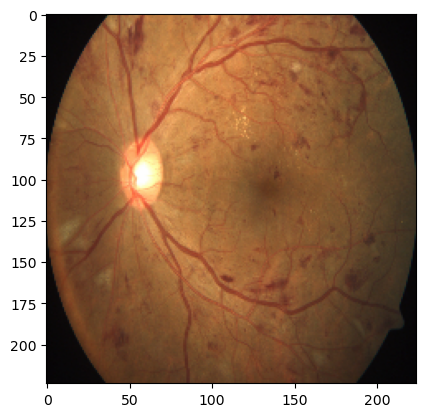

In [33]:
predict_new(r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\train\Severe\7b49041cbf17.png')